## Fig 3(c)

In [1]:
import scanpy as sc
import glob

import numpy as np
import pandas as pd
import pickle as pkl

from geosketch import gs
from fbpca import pca

import numpy as np
import pickle

import glob
from tqdm import tqdm

In [2]:
### Read in relevant IMA datasets
all_datasets = np.load('../all_datasets.npy')
all_datasets = np.unique(all_datasets)

In [3]:
#all_paths = glob.glob('/lfs/local/0/yanay/uce_all_proc_4layer/*')
#all_paths = [x for x in glob.glob('/lfs/local/0/yanay/uce_all_proc_4layer/*') 
#             if x.split('_')[-1].split('.npz')[0] in all_datasets]

all_paths = [x for x in glob.glob('/lfs/local/0/yanay/uce_all_proc_33_8ep/*') 
             if x.split('_')[-1].split('.npz')[0] in all_datasets]

# Get the total number of rows in the final matrix
total_rows = sum(int(path.split('cells_')[-1].split('_')[0]) for path in all_paths)

# Create a memory-mapped array to store the final matrix
giant_matrix = np.memmap('/lfs/local/0/yhr/uce_all_proc/fig4_big_matrix_33layer_', shape=(total_rows, 1280), dtype='float32', mode='w+')

# Write data from each file to the memory-mapped array 
current_row = 0
for path in tqdm(all_paths, desc='Progress', unit='file'):
    try:
        ncells = int(path.split('cells_')[-1].split('_')[0])
        arr = np.memmap(path, shape=(ncells, 1280), dtype="float32", mode='r')
        giant_matrix[current_row:current_row + ncells, :] = arr
        current_row += ncells
    except:
        print('ERROR', path)

## Flush the memory-mapped array to ensure data is written to disk
giant_matrix.flush()


"""
# Load Cell Types
ct_path = f"/lfs/local/0/yanay/all_cell_types/{name}.pkl"
with open(ct_path, "rb") as f:
    cell_types = pkl.load(f)
"""

Progress: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 184/184 [02:29<00:00,  1.23file/s]


'\n# Load Cell Types\nct_path = f"/lfs/local/0/yanay/all_cell_types/{name}.pkl"\nwith open(ct_path, "rb") as f:\n    cell_types = pkl.load(f)\n'

In [4]:
all_datasets = sc.AnnData(giant_matrix)

In [5]:
len(all_datasets)

19284565

### Read in annotations

In [7]:
import numpy as np
import glob
from tqdm import tqdm


In [8]:
import pickle
from tqdm import tqdm

annotations = []
annotations_dir = '/dfs/project/uce/model_output/all_cell_types/'

for path in tqdm(all_paths):
    fname = '_'.join(path.split('cells_')[-1].split('_')[1:])
    num_cells = int(path.split('cells_')[-1].split('_')[0])
    annotations_fname = annotations_dir + fname
    annotations_fname = annotations_fname.replace('.npz', '.pkl')
    try:
        with open(annotations_fname, 'rb') as file:
            loaded = pickle.load(file)
            assert(len(loaded)==num_cells)
            annotations.extend(loaded)
    except:
        print(annotations_fname +' not found')
        annotations.extend(['None'] * num_cells)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 184/184 [00:02<00:00, 76.87it/s]


In [9]:
len(annotations)

19284565

### Compute centroids for each cell type

In [10]:
centroids = {}
all_cell_types = list(set(annotations))

In [11]:
annotations = np.array(annotations)

In [12]:
for c in tqdm(all_cell_types, total=len(all_cell_types)):
    idxs = np.where(annotations==c)
    subset_matrix = giant_matrix[idxs]
    centroids[c] = np.mean(subset_matrix,0)
    

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 476/476 [03:41<00:00,  2.15it/s]


In [13]:
all_centroids = pd.DataFrame.from_dict(centroids)

In [14]:
all_centroids = all_centroids.T

In [15]:
all_centroids.to_csv('fig4_centroids_uce_33layer.csv')

### Concatenate the datasets

In [17]:
def new_donors(ad):
    # add donors and then filter
    ad.obs["donor_num"] = ad.obs["donor"].str.split("TSP", expand=True)[1].astype(int)
    return ad[ad.obs["donor_num"] > 15]

In [19]:
tabula_sapiens_norm = sc.read_h5ad('/dfs/project/cross-species/uce/new_tabula_sapiens_ep_8_sn_2013249_nlayers_33_sample_size_1024.h5ad')
tabula_unseen = new_donors(tabula_sapiens_norm)

In [20]:
tabula_33lay = sc.AnnData(tabula_unseen.obsm['X_uce'])
tabula_33lay.obs = pd.DataFrame(tabula_unseen.obs)
tabula_33lay.obs['cell_type'] = tabula_33lay.obs['cell_ontology_class'].values

In [21]:
tabula_33lay.obs['cell_type'] = [c + ' (New)' for c in tabula_33lay.obs['cell_type'].values]

In [26]:
cell_types = annotations.tolist() + tabula_33lay.obs['cell_type'].values.tolist()
datasets = ['CxG'] * len(annotations) + ['TS'] * len(tabula_33lay)

In [27]:
concat_adata = sc.concat([all_datasets, tabula_33lay])

In [ ]:
sc.pp.neighbors(concat_adata)

         Falling back to preprocessing with `sc.pp.pca` and default params.


In [ ]:
concat_adata.obs['dataset'] = datasets
concat_adata.obs['cell_type'] = cell_types

In [ ]:
concat_adata

In [47]:
concat_adata

AnnData object with n_obs × n_vars = 35582819 × 1280
    obs: 'dataset', 'cell_type'
    uns: 'neighbors'
    obsm: 'X_pca'
    obsp: 'distances', 'connectivities'

In [ ]:
concat_adata.obs['cell_type'] = pd.Categorical(concat_adata.obs['cell_type'])

- Add tissue label to cell types
- Compute dendrograms
- Measure performance

In [ ]:
sc.tl.dendrogram(concat_adata, groupby='cell_type')

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

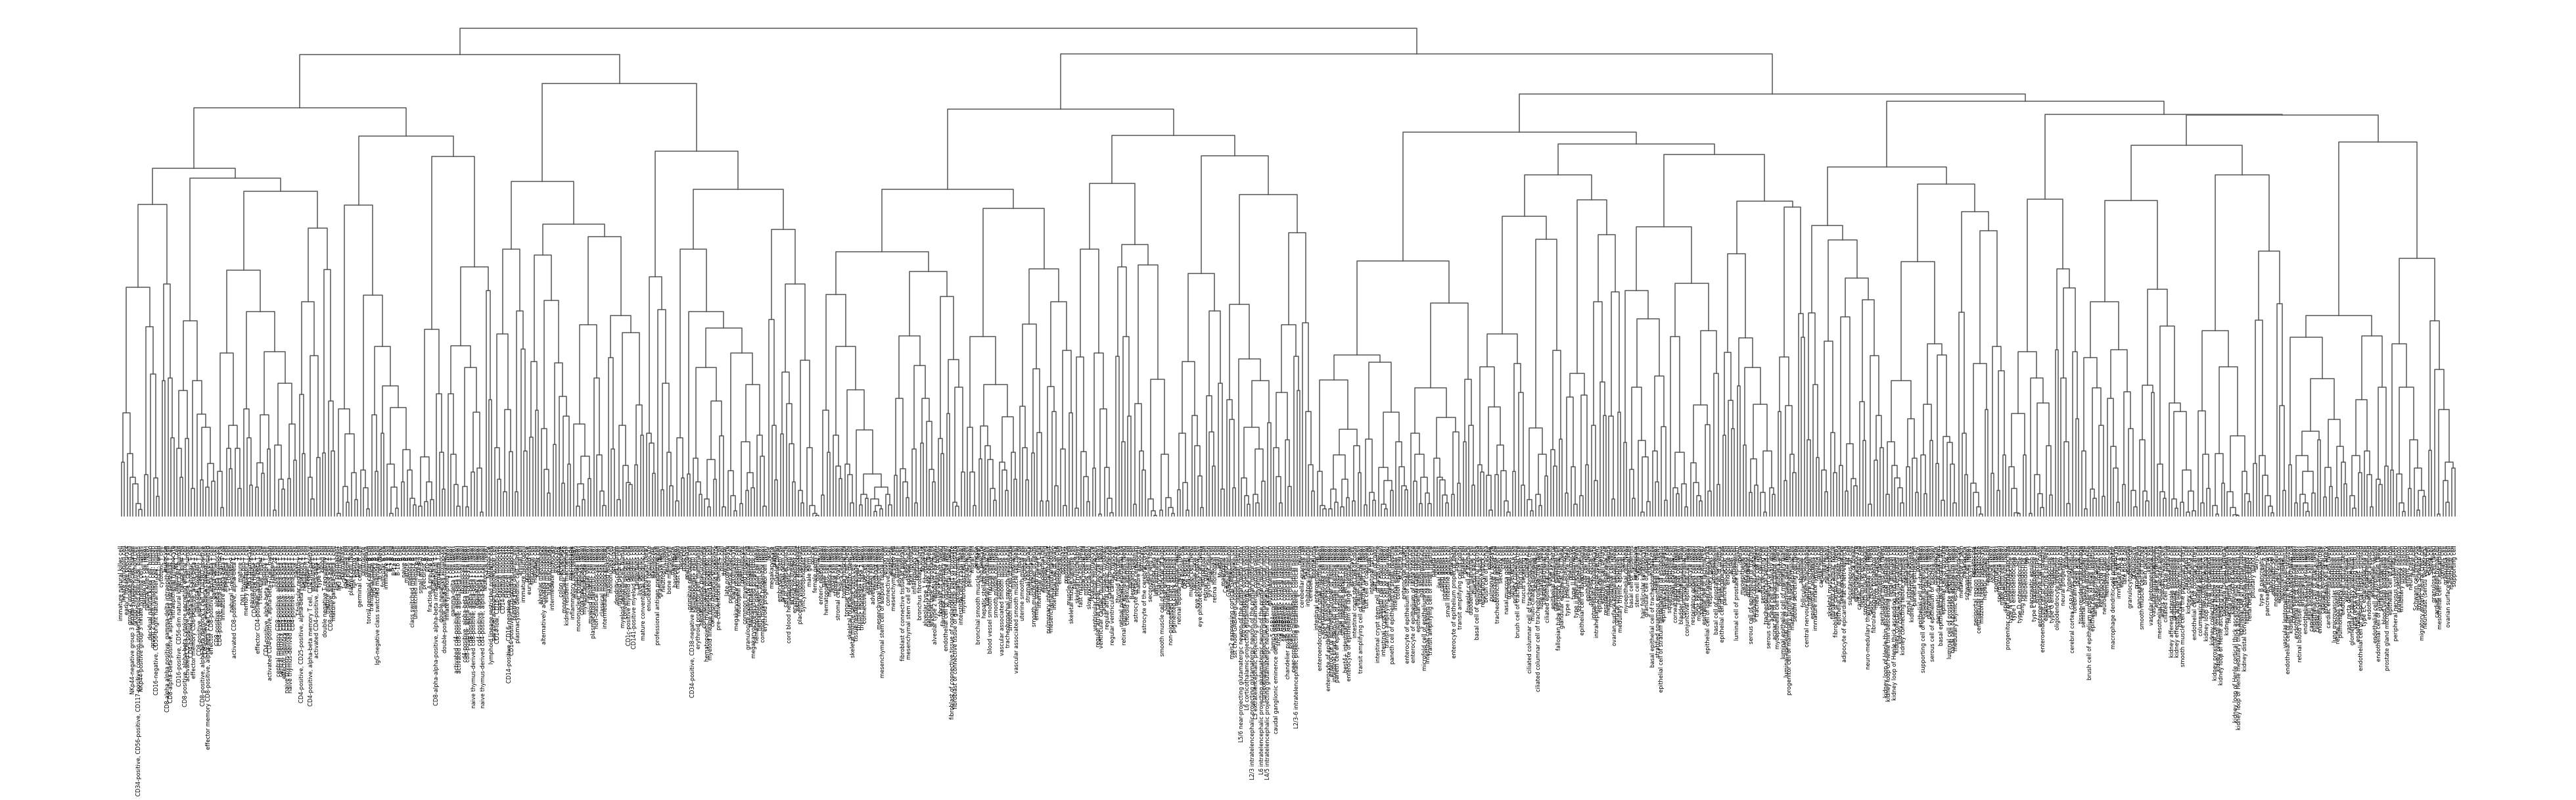

<AxesSubplot:>

In [54]:
plt.figure(figsize=[70,15])
ax = plt.gca()
sc.pl.dendrogram(concat_adata, groupby='cell_type', ax=ax)

### Subset tabula by tissue

In [ ]:
import pandas as pd
from sklearn.neighbors import NearestNeighbors
results_dict = {}

In [ ]:
tabula_33lay.obs['cell_type'] = tabula_33lay.obs['cell_ontology_class']

In [38]:
tissue = 'Bladder'

In [20]:
num_nbrs=2

In [40]:
def get_nn_results(concat_centroids, num_nbrs=[2], max_possible=None):
    
    results_dict = {}
    for n_neighbors in num_nbrs:

        # Create a NearestNeighbors model
        nn_model = NearestNeighbors(n_neighbors=n_neighbors)

        # Fit the model to your data
        nn_model.fit(concat_centroids)

        # Find the 1 nearest neighbor for each row
        distances, indices = nn_model.kneighbors(concat_centroids)

        # Create a new DataFrame to store the nearest neighbors and distances
        nearest_neighbors_dict = {concat_centroids.index[i]: np.array(concat_centroids.index)[indices[i, 1:n_neighbors]] 
                              for i in range(len(concat_centroids))
                              if '_TS' in concat_centroids.index[i]}

        matches = []
        not_matched = []

        for cell, neighbors in nearest_neighbors_dict.items():
            not_matched_flag = 1
            for n in neighbors:
                if cell.strip('_TS').lower() == n.lower():
                    not_matched_flag = 0
                    matches.append(cell)
                    break
            if not_matched_flag == 1:
                not_matched.append(cell)  

        not_matched = list(set(not_matched))
        if max_possible is not None:
            results_dict[n_neighbors] = len(matches)/max_possible
        else:
            results_dict[n_neighbors] = len(matches)
    
    return results_dict, not_matched

In [80]:
all_results = {}
num_nbrs = 4 ## This is n+1

for tissue in tabula_33lay.obs['tissue'].unique():
    print(tissue)
    
    tabula_tissue = tabula_33lay[tabula_33lay.obs['tissue']==tissue]
    tabula_tissue_df = tabula_tissue.to_df()
    tabula_tissue_df['cell_type'] = tabula_tissue.obs['cell_type']
    tabula_tissue_centroids = tabula_tissue_df.groupby('cell_type').mean()
    tabula_tissue_centroids.index = [x+'_TS' for x in tabula_tissue_centroids.index.values]

    all_centroids.columns = all_centroids.columns.astype('str')
    tabula_tissue_centroids.columns = tabula_tissue_centroids.columns.astype('str')

    # Concatenate with IMA centroids
    concat_centroids = pd.concat([all_centroids, tabula_tissue_centroids])
    max_possible = len(set(tabula_tissue_df['cell_type'].unique().tolist()).intersection(
                        set(all_centroids.index.values)))
    
    
    results_dict, _ = get_nn_results(concat_centroids, 
                                     num_nbrs=[num_nbrs],
                                     max_possible=max_possible)

    all_results[tissue] = results_dict

np.save(f'nn_{num_nbrs}_uce', all_results)

Ovary
Stomach
Fat
Thymus
Blood
Bladder
Small_Intestine
Salivary_Gland
Skin
Muscle
Bone_Marrow
Lung
Testis
Lymph_Node
Vasculature
Ear
Spleen
Large_Intestine
Trachea
Prostate
Uterus
Pancreas
Eye
Liver
Mammary
Heart
Tongue


### Plot bar plot

In [21]:
all_results_uce = np.load(f'nn_{num_nbrs}_uce.npy', allow_pickle=True).item()
all_results_raw = np.load(f'../nn_{num_nbrs}_raw.npy', allow_pickle=True).item()

In [6]:
#all_results_uce_4lay = np.load(f'../nn_{num_nbrs}_uce.npy', allow_pickle=True).item()

#diffs = {}
#for k in all_results_uce.keys():
#    diffs[k] = all_results_uce_33lay[k][num_nbrs] - all_results_uce_4lay[k][num_nbrs]

In [8]:
import matplotlib
font = {'family' : 'normal',
        'size'   : 18}

matplotlib.rc('font', **font)

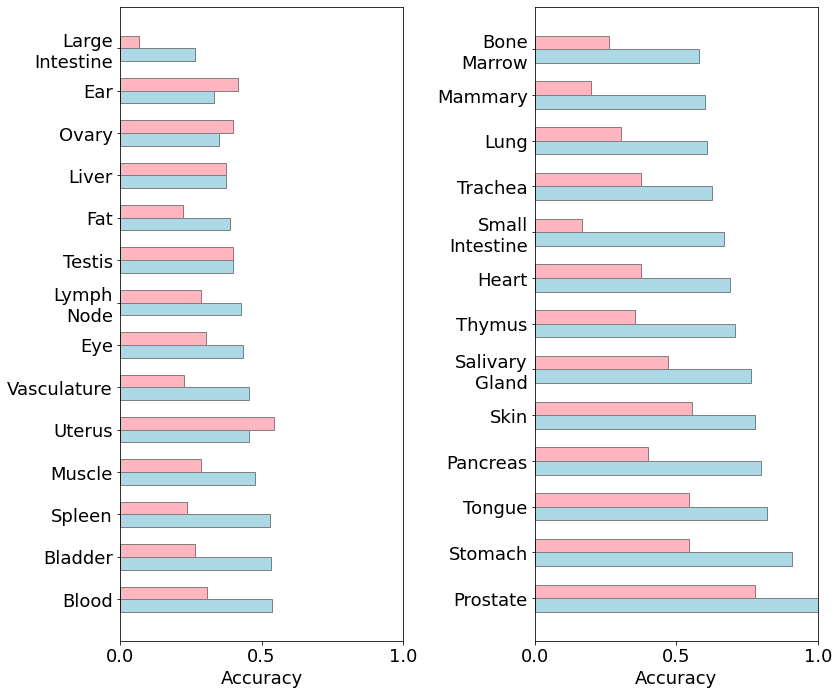

In [10]:
import matplotlib.pyplot as plt
import numpy as np

tissues = list(all_results_uce.keys())
uce_scores = [all_results_uce[t][num_nbrs] for t in tissues]
raw_scores = [all_results_raw[t][num_nbrs] for t in tissues]

# Calculating percentage improvements of UCE over Raw
percentage_improvement = [(u - r) / r * 100 for u, r in zip(uce_scores, raw_scores)]

# Sorting tissues based on percentage improvement, in descending order
#sorted_indices = np.argsort(percentage_improvement)[::-1]
sorted_indices = np.argsort(uce_scores)[::-1]

# Reordering tissues, uce_scores, and raw_scores based on sorted indices
tissues = [tissues[i] for i in sorted_indices]
uce_scores = [uce_scores[i] for i in sorted_indices]
raw_scores = [raw_scores[i] for i in sorted_indices]



barHeight = 0.3

# Splitting the data
half_len = len(tissues) // 2
tissues_2 = tissues[:half_len]
uce_scores_2 = uce_scores[:half_len]
raw_scores_2 = raw_scores[:half_len]

tissues_1 = tissues[half_len:]
uce_scores_1 = uce_scores[half_len:]
raw_scores_1 = raw_scores[half_len:]

plt.figure(figsize=[12, 10])  # Adjust as per your need

# First subplot
plt.subplot(1, 2, 1)

r1_1 = np.arange(len(tissues_1))
r2_1 = [x + barHeight for x in r1_1]

plt.barh(r1_1, uce_scores_1, color='#add8e6', height=barHeight, edgecolor='grey', label='Universal Embedding (UCE)')
plt.xlim([0,1])
plt.xticks([0,0.5,1])
plt.barh(r2_1, raw_scores_1, color='#ffb6c1', height=barHeight, edgecolor='grey', label='Original Data Representation')

plt.yticks([r + barHeight/2 for r in range(len(tissues_1))], 
          [x.replace('_', '\n') for x in tissues_1])
plt.xlabel('Accuracy')
#plt.legend(bbox_to_anchor=(1.0,1.15), ncol=2)
#plt.ylabel('Tissues')
#plt.title('Tissues 1')

# Second subplot
plt.subplot(1, 2, 2)

r1_2 = np.arange(len(tissues_2))
r2_2 = [x + barHeight for x in r1_2]

plt.barh(r1_2, uce_scores_2, color='#add8e6', height=barHeight, edgecolor='grey', label='Universal Embedding (UCE)')
plt.xlim([0,1])
plt.xticks([0,0.5,1])
plt.barh(r2_2, raw_scores_2, color='#ffb6c1', height=barHeight, edgecolor='grey', label='Original Data Representation')


plt.yticks([r + barHeight/2 for r in range(len(tissues_2))], 
           [x.replace('_', '\n') for x in tissues_2])
plt.xlabel('Accuracy')
#plt.title('Tissues 2')


# Create legend & Adjust layout
plt.tight_layout()

# Save figure
plt.savefig('fig3e.svg', dpi=300)
plt.show()